# Collaborative Filtering with Neural Nets

In [1]:
# for data manipulation
import numpy as np
import pandas as pd
import os
import pickle

# use surprise for collaborative filtering
import torch
import torch.nn as nn
from torch.autograd import Variable

/home/shared/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Read in data

In [30]:
game_data_path = "data/neural_net_data/"
files = sorted(os.listdir(game_data_path))
start = 5
with open(game_data_path + files[start], 'rb') as f:
    print(files[start])
    X, y = pickle.load(f, encoding='latin1')
for i in range(1):
    with open(game_data_path + files[start + 1 + i], 'rb') as f:
        print(files[start + 1 + i])
        X_add, y_add = pickle.load(f, encoding='latin1')
        print(X.shape)
        print(X_add.shape)
        X = np.concatenate((X, X_add), axis = 0)
        y = np.concatenate((y, y_add), axis = 0)

2013-2014.pkl
2014-2015.pkl
(1272, 3, 508)
(1263, 3, 508)


In [22]:
X.shape

torch.Size([2475, 1524])

In [23]:
y.shape

torch.Size([2475, 1])

In [5]:
def trainValSplit(X, y):
    X = np.array(X)
    y = np.array(y)

    X = X[y > 0]
    y = y[y > 0]

    p = np.random.permutation(len(X))
    X = X[p]
    y = y[p]

    val = 0.2
    val = round(len(X) * val)
    X_val = X[:val]
    y_val = y[:val]
    X = X[val:]
    y = y[val:]
    
    return X, y, X_val, y_val

In [6]:
X, y, X_val, y_val = trainValSplit(X, y)

In [31]:
# BySeason trainValSplit
game_data_path = "data/neural_net_data/"
files = sorted(os.listdir(game_data_path))
with open(game_data_path + files[7], 'rb') as f:
    print(files[7])
    X_val, y_val = pickle.load(f, encoding='latin1')
    
X = X[y > 0]
y = y[y > 0]
X_val = X_val[y_val > 0]
y_val = y_val[y_val > 0]

2015-2016.pkl


In [32]:
y = torch.from_numpy(y[:,np.newaxis]).type(torch.FloatTensor)
X = torch.from_numpy(X.reshape((X.shape[0], -1))).type(torch.FloatTensor)
y_val = torch.from_numpy(y_val[:,np.newaxis]).type(torch.FloatTensor)
X_val = torch.from_numpy(X_val.reshape((X_val.shape[0], -1))).type(torch.FloatTensor)

In [33]:
# Split train/test:
print(y[:10])

tensor([[ 185.],
        [ 255.],
        [ 183.],
        [ 200.],
        [ 192.],
        [ 227.],
        [ 190.],
        [ 202.],
        [ 199.],
        [ 217.]])


In [34]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()
        
        # layer 1 fully connected 150 units
        self.lin1 = nn.Linear(n_feature, 500)
        
        # layer 2 fully connected 50 units
        self.lin2 = nn.Linear(500, 100)
        
        # layer 3 fully connected 1 unit (output)
        self.lin3 = nn.Linear(100, n_output)
        
        # self.lin4 = nn.Linear(50, n_output)
        
        # dropouts
        self.drop1 = nn.Dropout(0.5)
        self.drop2 = nn.Dropout(0.4)
        self.drop3 = nn.Dropout(0.25)

    def forward(self, x):
        # perform dropout on input vector embeddings
        # x = self.drop1(x)
        x = F.relu(self.lin1(x))
        # x = self.drop2(F.relu(self.lin1(x)))
        x = F.relu(self.lin2(x))
        # x = self.drop3(F.relu(self.lin2(x)))
        x = self.lin3(x)
        
        return x  

net = Net(n_feature=1524, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.000001, weight_decay = 1e-2)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

# plt.ion()   # something about plotting

for t in range(10000):
    prediction = net(X)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    # Do validation loss
    with torch.no_grad():
        pred_val = net(X_val)
        loss_val = loss_func(pred_val, y_val)

    if t % 100 == 0:
        # plot and show learning process
        '''
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)
        '''
        print("-----")
        print(t)
        print('Loss=%.4f' % loss.data.numpy())
        print('Val Loss=%.4f' % loss_val.data.numpy())

# plt.ioff()
# plt.show()

Net(
  (lin1): Linear(in_features=1524, out_features=500, bias=True)
  (lin2): Linear(in_features=500, out_features=100, bias=True)
  (lin3): Linear(in_features=100, out_features=1, bias=True)
  (drop1): Dropout(p=0.5)
  (drop2): Dropout(p=0.4)
  (drop3): Dropout(p=0.25)
)
-----
0
Loss=36825.2031
Val Loss=7107.9331
-----
100
Loss=1170.4954
Val Loss=10611.4912
-----
200
Loss=807.7614
Val Loss=10225.2627
-----
300
Loss=677.3436
Val Loss=10075.8594


KeyboardInterrupt: 

## Try on more data

In [79]:
game_data_path = "data/neural_net_data/"
files = sorted(os.listdir(game_data_path))

files = ["2012-2013.pkl", "2013-2014.pkl", "2014-2015.pkl", "2015-2016.pkl","2016-2017.pkl", "2017-2018.pkl"]

X_train = np.zeros(5)

for file in files[:-2]:
    if ".pkl" not in file: continue
    
    with open(game_data_path + file, 'rb') as f:
        print(file)
        if X_train.shape[0] == 5:
            X_train, y_train = pickle.load(f, encoding='latin1')
        else:
            X_add, y_add = pickle.load(f, encoding='latin1')
            print(X_train.shape)
            print(X_add.shape)
            X_train = np.concatenate((X_train, X_add), axis = 0)
            y_train = np.concatenate((y_train, y_add), axis = 0)

with open(game_data_path + files[-2], 'rb') as f:
        print(files[-2])
        X_val, y_val = pickle.load(f, encoding='latin1')
        
with open(game_data_path + files[-1], 'rb') as f:
        print(files[-1])
        X_test, y_test = pickle.load(f, encoding='latin1')

2012-2013.pkl
2013-2014.pkl
(1265, 3, 508)
(1272, 3, 508)
2014-2015.pkl
(2537, 3, 508)
(1263, 3, 508)
2015-2016.pkl
(3800, 3, 508)
(1269, 3, 508)
2016-2017.pkl
2017-2018.pkl


In [80]:
def clean_data(X, y):
    X = X[y > 0]
    y = y[y > 0]
    
    return X, y

In [81]:
X, y = clean_data(X_train, y_train)
X_val, y_val = clean_data(X_val, y_val)
X_test, y_test = clean_data(X_test, y_test)

In [82]:
y = torch.from_numpy(y[:,np.newaxis]).type(torch.FloatTensor)
X = torch.from_numpy(X.reshape((X.shape[0], -1))).type(torch.FloatTensor)
y_val = torch.from_numpy(y_val[:,np.newaxis]).type(torch.FloatTensor)
X_val = torch.from_numpy(X_val.reshape((X_val.shape[0], -1))).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test[:,np.newaxis]).type(torch.FloatTensor)
X_test = torch.from_numpy(X_test.reshape((X_test.shape[0], -1))).type(torch.FloatTensor)

In [48]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()
        
        # layer 1 fully connected 150 units
        self.lin1 = nn.Linear(n_feature, 100)
        
        # layer 2 fully connected 50 units
        self.lin2 = nn.Linear(100, 20)
        self.lin3 = nn.Linear(20, n_output)
        

    def forward(self, x):
        # perform dropout on input vector embeddings
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        
        return x  

net = Net(n_feature=1524, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=1e-6, weight_decay = 1)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

# plt.ion()   # something about plotting

for t in range(10000):
    prediction = net(X)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    # Do validation loss
    with torch.no_grad():
        pred_val = net(X_val)
        loss_val = loss_func(pred_val, y_val)

    if t % 100 == 0:
        # plot and show learning process
        '''
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)
        '''
        print("-----")
        print(t)
        print('Loss=%.4f' % loss.data.numpy())
        print('Val Loss=%.4f' % loss_val.data.numpy())

# plt.ioff()
# plt.show()

Net(
  (lin1): Linear(in_features=1524, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=20, bias=True)
  (lin3): Linear(in_features=20, out_features=1, bias=True)
)
-----
0
Loss=33785.3164
Val Loss=8918.6826
-----
100
Loss=1563.3461
Val Loss=2937.0347
-----
200
Loss=985.1339
Val Loss=1594.7726
-----
300
Loss=765.8445
Val Loss=1144.1522
-----
400
Loss=654.3577
Val Loss=932.2725
-----
500
Loss=595.5217
Val Loss=825.0071
-----
600
Loss=556.5037
Val Loss=755.7455
-----
700
Loss=525.3077
Val Loss=701.0831
-----
800
Loss=502.7728
Val Loss=662.5638
-----
900
Loss=484.7969
Val Loss=631.7883
-----
1000
Loss=471.7117
Val Loss=609.6647
-----
1100
Loss=458.5612
Val Loss=587.8519
-----
1200
Loss=447.8412
Val Loss=569.7866
-----
1300
Loss=442.5939
Val Loss=560.9316
-----
1400
Loss=439.7016
Val Loss=555.8060
-----
1500
Loss=431.0389
Val Loss=541.8175
-----
1600
Loss=424.8046
Val Loss=531.2537
-----
1700
Loss=423.2522
Val Loss=529.3687
-----
1800
Loss=411.8873
Val Loss=509.

KeyboardInterrupt: 

## Try with different architectures

In [49]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()
        
        # layer 1 fully connected 150 units
        self.lin1 = nn.Linear(n_feature, 500)
        
        # layer 2 fully connected 50 units
        self.lin2 = nn.Linear(500, 100)
        self.lin3 = nn.Linear(100, n_output)
        

    def forward(self, x):
        # perform dropout on input vector embeddings
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        
        return x  

net = Net(n_feature=1524, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=1e-6, weight_decay = 1)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

# plt.ion()   # something about plotting

for t in range(10000):
    prediction = net(X)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    # Do validation loss
    with torch.no_grad():
        pred_val = net(X_val)
        loss_val = loss_func(pred_val, y_val)

    if t % 100 == 0:
        # plot and show learning process
        '''
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)
        '''
        print("-----")
        print(t)
        print('Loss=%.4f' % loss.data.numpy())
        print('Val Loss=%.4f' % loss_val.data.numpy())

# plt.ioff()
# plt.show()

Net(
  (lin1): Linear(in_features=1524, out_features=500, bias=True)
  (lin2): Linear(in_features=500, out_features=100, bias=True)
  (lin3): Linear(in_features=100, out_features=1, bias=True)
)
-----
0
Loss=42581.4375
Val Loss=10719.4131
-----
100
Loss=1306.5361
Val Loss=2321.2966
-----
200
Loss=850.5865
Val Loss=1298.9583
-----
300
Loss=689.8105
Val Loss=990.5787
-----
400
Loss=608.4941
Val Loss=843.3696
-----
500
Loss=557.8242
Val Loss=754.6586
-----
600
Loss=524.5273
Val Loss=698.3322


KeyboardInterrupt: 

In [50]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()
        
        # layer 1 fully connected 150 units
        self.lin1 = nn.Linear(n_feature, 100)
        
        # layer 2 fully connected 50 units
        self.lin2 = nn.Linear(100, 20)
        self.lin3 = nn.Linear(20, n_output)
        

    def forward(self, x):
        # perform dropout on input vector embeddings
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        
        return x  

net = Net(n_feature=1524, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=1e-6, weight_decay = 10)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

# plt.ion()   # something about plotting

for t in range(10000):
    prediction = net(X)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    # Do validation loss
    with torch.no_grad():
        pred_val = net(X_val)
        loss_val = loss_func(pred_val, y_val)

    if t % 100 == 0:
        # plot and show learning process
        '''
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)
        '''
        print("-----")
        print(t)
        print('Loss=%.4f' % loss.data.numpy())
        print('Val Loss=%.4f' % loss_val.data.numpy())

# plt.ioff()
# plt.show()

Net(
  (lin1): Linear(in_features=1524, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=20, bias=True)
  (lin3): Linear(in_features=20, out_features=1, bias=True)
)
-----
0
Loss=37606.9297
Val Loss=11558.6992
-----
100
Loss=1368.6725
Val Loss=2553.0046
-----
200
Loss=955.1909
Val Loss=1541.4231
-----
300
Loss=795.8029
Val Loss=1208.0969
-----
400
Loss=709.5984
Val Loss=1038.4926
-----
500
Loss=646.3178
Val Loss=915.2849
-----
600
Loss=610.1110
Val Loss=848.4869
-----
700
Loss=574.7874
Val Loss=783.7828
-----
800
Loss=548.4568
Val Loss=736.1489
-----
900
Loss=527.2394
Val Loss=699.5761
-----
1000
Loss=510.4058
Val Loss=671.8802
-----
1100
Loss=492.3026
Val Loss=641.2138
-----
1200
Loss=477.6333
Val Loss=615.8599
-----
1300
Loss=468.2047
Val Loss=600.1415
-----
1400
Loss=455.9815
Val Loss=580.1837
-----
1500
Loss=448.0787
Val Loss=567.5602
-----
1600
Loss=443.2267
Val Loss=560.1873
-----
1700
Loss=435.6959
Val Loss=547.8133
-----
1800
Loss=430.2346
Val Loss=53

In [53]:
max_score,min_score = y.max(),y.min()

In [54]:
max_score

tensor(291.)

In [61]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()
        
        # layer 1 fully connected 150 units
        self.lin1 = nn.Linear(n_feature, 100)
        
        # layer 2 fully connected 50 units
        self.lin2 = nn.Linear(100, n_output)
        

    def forward(self, x):
        # perform dropout on input vector embeddings
        x = F.relu(self.lin1(x))
        # x = F.relu(self.lin2(x))
        x = F.sigmoid(self.lin2(x)) * (max_score-min_score+1) + min_score-0.5
        
        return x  

net = Net(n_feature=1524, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=1)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

# plt.ion()   # something about plotting

for t in range(10000):
    prediction = net(X)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    # Do validation loss
    with torch.no_grad():
        pred_val = net(X_val)
        loss_val = loss_func(pred_val, y_val)

    if t % 10 == 0:
        # plot and show learning process
        '''
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)
        '''
        print("-----")
        print(t)
        print('Loss=%.4f' % loss.data.numpy())
        print('Val Loss=%.4f' % loss_val.data.numpy())

# plt.ioff()
# plt.show()

Net(
  (lin1): Linear(in_features=1524, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=1, bias=True)
)
-----
0
Loss=6283.0562
Val Loss=6437.1416
-----
10
Loss=4894.1030
Val Loss=6437.1416
-----
20
Loss=4894.1030
Val Loss=6437.1416
-----
30
Loss=4894.1030
Val Loss=6437.1416
-----
40
Loss=4894.1030
Val Loss=6437.1416
-----
50
Loss=4894.1030
Val Loss=6437.1416
-----
60
Loss=4894.1030
Val Loss=6437.1416
-----
70
Loss=4894.1030
Val Loss=6437.1416
-----
80
Loss=4894.1030
Val Loss=6437.1416
-----
90
Loss=4894.1030
Val Loss=6437.1416
-----
100
Loss=4894.1030
Val Loss=6437.1416
-----
110
Loss=4894.1030
Val Loss=6437.1416
-----
120
Loss=4894.1030
Val Loss=6437.1416
-----
130
Loss=4894.1030
Val Loss=6437.1416
-----
140
Loss=4894.1030
Val Loss=6437.1416


KeyboardInterrupt: 

## Deeper network?

In [83]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()
        
        # layer 1 fully connected 150 units
        self.lin1 = nn.Linear(n_feature, 500)
        
        # layer 2 fully connected 50 units
        self.lin2 = nn.Linear(500, 100)
        self.lin3 = nn.Linear(100, 20)
        self.lin4 = nn.Linear(20, n_output)
        

    def forward(self, x):
        # perform dropout on input vector embeddings
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = self.lin4(x)
        
        return x  

net = Net(n_feature=1524, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=1e-6, weight_decay = 1)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

# plt.ion()   # something about plotting

losses = []
val_losses = []
for t in range(5000):
    prediction = net(X)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    # Do validation loss
    with torch.no_grad():
        pred_val = net(X_val)
        loss_val = loss_func(pred_val, y_val)

    if t % 100 == 0:
        # plot and show learning process
        '''
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)
        '''
        print("-----")
        print(t)
        print('Loss=%.4f' % loss.data.numpy())
        print('Val Loss=%.4f' % loss_val.data.numpy())
        losses.append(loss.data.numpy())
        val_losses.append(loss_val.data.numpy())

# plt.ioff()
# plt.show()

Net(
  (lin1): Linear(in_features=1524, out_features=500, bias=True)
  (lin2): Linear(in_features=500, out_features=100, bias=True)
  (lin3): Linear(in_features=100, out_features=20, bias=True)
  (lin4): Linear(in_features=20, out_features=1, bias=True)
)
-----
0
Loss=38260.6602
Val Loss=32118.7559
-----
100
Loss=1203.2887
Val Loss=2061.3198
-----
200
Loss=687.3368
Val Loss=992.9130
-----
300
Loss=542.2668
Val Loss=727.0233
-----
400
Loss=482.4226
Val Loss=624.8755
-----
500
Loss=448.2942
Val Loss=568.5328
-----
600
Loss=428.9934
Val Loss=536.9005
-----
700
Loss=417.5521
Val Loss=518.4960
-----
800
Loss=409.3563
Val Loss=505.0832
-----
900
Loss=398.0174
Val Loss=486.2299
-----
1000
Loss=391.3517
Val Loss=475.3676
-----
1100
Loss=381.5217
Val Loss=458.7466
-----
1200
Loss=377.2135
Val Loss=451.6601
-----
1300
Loss=374.6504
Val Loss=447.6359
-----
1400
Loss=370.7366
Val Loss=441.0936
-----
1500
Loss=367.8433
Val Loss=436.3712
-----
1600
Loss=364.0118
Val Loss=429.7424
-----
1700
Loss=359

In [89]:
epochs = 100*(np.arange(50) + 1)

ValueError: x and y must have same first dimension, but have shapes (1,) and (50,)

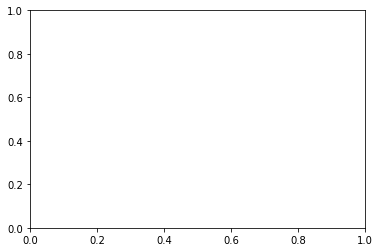

In [88]:
plt.plot(5000, losses, color="red", label="Test Error")
plt.plot(5000, val_losses, color="blue", label="Train Error")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("MSE vs. Epochs (LSTM)")
# plt.savefig("lstm_train.jpg")
plt.show()

In [64]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()
        
        # layer 1 fully connected 150 units
        self.lin1 = nn.Linear(n_feature, 500)
        
        # layer 2 fully connected 50 units
        self.lin2 = nn.Linear(500, 200)
        self.lin3 = nn.Linear(200, 50)
        self.lin4 = nn.Linear(50, 10)
        self.lin5 = nn.Linear(10, n_output)
        

    def forward(self, x):
        # perform dropout on input vector embeddings
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = F.relu(self.lin4(x))
        x = self.lin5(x)
        
        return x  

net = Net(n_feature=1524, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=1e-6, weight_decay = 1)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

# plt.ion()   # something about plotting

for t in range(10000):
    prediction = net(X)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    # Do validation loss
    with torch.no_grad():
        pred_val = net(X_val)
        loss_val = loss_func(pred_val, y_val)

    if t % 10 == 0:
        # plot and show learning process
        '''
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)
        '''
        print("-----")
        print(t)
        print('Loss=%.4f' % loss.data.numpy())
        print('Val Loss=%.4f' % loss_val.data.numpy())

# plt.ioff()
# plt.show()

Net(
  (lin1): Linear(in_features=1524, out_features=500, bias=True)
  (lin2): Linear(in_features=500, out_features=200, bias=True)
  (lin3): Linear(in_features=200, out_features=50, bias=True)
  (lin4): Linear(in_features=50, out_features=10, bias=True)
  (lin5): Linear(in_features=10, out_features=1, bias=True)
)
-----
0
Loss=41027.6523
Val Loss=44475.3789
-----
10
Loss=19628.6055
Val Loss=14524.2520
-----
20
Loss=5190.3882
Val Loss=5981.8555
-----
30
Loss=3884.6340
Val Loss=4650.5967
-----
40
Loss=2937.4805
Val Loss=3663.1064
-----
50
Loss=2283.9312
Val Loss=2945.1121
-----
60
Loss=1808.6974
Val Loss=2380.6660
-----
70
Loss=1423.9235
Val Loss=1894.7966
-----
80
Loss=1104.2139
Val Loss=1475.8422
-----
90
Loss=845.6357
Val Loss=1127.8082
-----
100
Loss=668.0111
Val Loss=853.1544
-----
110
Loss=2664.2532
Val Loss=2561.8818
-----
120
Loss=1752.3610
Val Loss=1026.6965
-----
130
Loss=1409.2616
Val Loss=909.9985
-----
140
Loss=1422.6881
Val Loss=898.7137
-----
150
Loss=1295.6401
Val Loss=8

-----
1850
Loss=355.2239
Val Loss=369.7361
-----
1860
Loss=355.2445
Val Loss=369.7366
-----
1870
Loss=355.2372
Val Loss=369.7373
-----
1880
Loss=355.2397
Val Loss=369.7376
-----
1890
Loss=355.2574
Val Loss=369.7370
-----
1900
Loss=355.2547
Val Loss=369.7366
-----
1910
Loss=355.2372
Val Loss=369.7352
-----
1920
Loss=355.2008
Val Loss=369.7334
-----
1930
Loss=355.1436
Val Loss=369.7316
-----
1940
Loss=355.0762
Val Loss=369.7285
-----
1950
Loss=354.9994
Val Loss=369.7243
-----
1960
Loss=354.9267
Val Loss=369.7209
-----
1970
Loss=354.8502
Val Loss=369.7162
-----
1980
Loss=354.7498
Val Loss=369.7127
-----
1990
Loss=354.6483
Val Loss=369.7100
-----
2000
Loss=354.5378
Val Loss=369.7078
-----
2010
Loss=354.4214
Val Loss=369.7071
-----
2020
Loss=354.2861
Val Loss=369.7054
-----
2030
Loss=354.1297
Val Loss=369.7048
-----
2040
Loss=353.9742
Val Loss=369.7064
-----
2050
Loss=353.8115
Val Loss=369.7094
-----
2060
Loss=353.6440
Val Loss=369.7136
-----
2070
Loss=353.4841
Val Loss=369.7190
-----
2080


KeyboardInterrupt: 

## Try temporal convolutions

In [66]:
game_data_path = "data/neural_net_data/"
files = sorted(os.listdir(game_data_path))

files = ["2012-2013.pkl", "2013-2014.pkl", "2014-2015.pkl", "2015-2016.pkl","2016-2017.pkl", "2017-2018.pkl"]

X_train = np.zeros(5)

for file in files[:-2]:
    if ".pkl" not in file: continue
    
    with open(game_data_path + file, 'rb') as f:
        print(file)
        if X_train.shape[0] == 5:
            X_train, y_train = pickle.load(f, encoding='latin1')
        else:
            X_add, y_add = pickle.load(f, encoding='latin1')
            print(X_train.shape)
            print(X_add.shape)
            X_train = np.concatenate((X_train, X_add), axis = 0)
            y_train = np.concatenate((y_train, y_add), axis = 0)

with open(game_data_path + files[-2], 'rb') as f:
        print(files[-2])
        X_val, y_val = pickle.load(f, encoding='latin1')
        
with open(game_data_path + files[-1], 'rb') as f:
        print(files[-1])
        X_test, y_test = pickle.load(f, encoding='latin1')

2012-2013.pkl
2013-2014.pkl
(1265, 3, 508)
(1272, 3, 508)
2014-2015.pkl
(2537, 3, 508)
(1263, 3, 508)
2015-2016.pkl
(3800, 3, 508)
(1269, 3, 508)
2016-2017.pkl
2017-2018.pkl


In [67]:
def clean_data(X, y):
    X = X[y > 0]
    y = y[y > 0]
    
    return X, y

In [68]:
X, y = clean_data(X_train, y_train)
X_val, y_val = clean_data(X_val, y_val)
X_test, y_test = clean_data(X_test, y_test)

In [69]:
y = torch.from_numpy(y[:,np.newaxis]).type(torch.FloatTensor)
X = torch.from_numpy(X).type(torch.FloatTensor)
y_val = torch.from_numpy(y_val[:,np.newaxis]).type(torch.FloatTensor)
X_val = torch.from_numpy(X_val).type(torch.FloatTensor)

In [70]:
X.shape

torch.Size([4961, 3, 508])

In [78]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()
        
        # layer 1 fully connected 150 units
        # self.lin1 = nn.Linear(n_feature, 100)
        
        # layer 2 fully connected 50 units
        # self.lin2 = nn.Linear(100, 20)
        # self.lin3 = nn.Linear(20, n_output)
        
        self.conv1 = nn.Conv1d(3,150,kernel_size = 508)
        self.lin1 = nn.Linear(150, 50)
        self.lin2 = nn.Linear(50, n_output)

    def forward(self, x):
        # perform dropout on input vector embeddings
        x = F.relu(self.conv1(x))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        
        return x  

net = Net(n_feature=1524, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=1e-6, weight_decay = 1)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

# plt.ion()   # something about plotting

for t in range(10000):
    prediction = net(X)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    # Do validation loss
    with torch.no_grad():
        pred_val = net(X_val)
        loss_val = loss_func(pred_val, y_val)

    if t % 10 == 0:
        # plot and show learning process
        '''
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)
        '''
        print("-----")
        print(t)
        print('Loss=%.4f' % loss.data.numpy())
        print('Val Loss=%.4f' % loss_val.data.numpy())

# plt.ioff()
# plt.show()

Net(
  (conv1): Conv1d(3, 150, kernel_size=(508,), stride=(1,))
  (lin1): Linear(in_features=150, out_features=50, bias=True)
  (lin2): Linear(in_features=50, out_features=1, bias=True)
)
-----
0
Loss=37214.9180
Val Loss=11678.8203
-----
10
Loss=4439.6040
Val Loss=8365.9746
-----
20
Loss=3227.7144
Val Loss=6480.4014
-----
30
Loss=2631.0728
Val Loss=5450.3979
-----
40
Loss=2298.3240
Val Loss=4819.7783
-----
50
Loss=2058.1562
Val Loss=4295.7886
-----
60
Loss=1877.6304
Val Loss=3861.4360
-----
70
Loss=1733.9609
Val Loss=3501.6238
-----
80
Loss=1609.5328
Val Loss=3177.9939
-----
90
Loss=1510.3425
Val Loss=2921.5898
-----
100
Loss=1421.0330
Val Loss=2689.3794
-----
110
Loss=1347.0741
Val Loss=2499.1250
-----
120
Loss=1283.6223
Val Loss=2336.9709
-----
130
Loss=1229.1184
Val Loss=2201.0745
-----
140
Loss=1179.6904
Val Loss=2078.8281
-----
150
Loss=1134.8365
Val Loss=1969.3644
-----
160
Loss=1095.9230
Val Loss=1876.0896
-----
170
Loss=1062.7239
Val Loss=1796.6823
-----
180
Loss=1030.9600
Val 

-----
1880
Loss=423.5368
Val Loss=530.7604
-----
1890
Loss=422.7183
Val Loss=529.4564
-----
1900
Loss=421.9995
Val Loss=528.2945
-----
1910
Loss=421.6255
Val Loss=527.7038
-----
1920
Loss=421.3592
Val Loss=527.2621
-----
1930
Loss=421.1794
Val Loss=527.0029
-----
1940
Loss=420.9837
Val Loss=526.6664
-----
1950
Loss=420.9526
Val Loss=526.5855
-----
1960
Loss=421.1181
Val Loss=526.9565
-----
1970
Loss=421.7203
Val Loss=528.0994
-----
1980
Loss=422.0638
Val Loss=528.6963
-----
1990
Loss=421.9872
Val Loss=528.6566
-----
2000
Loss=421.7113
Val Loss=528.2611
-----
2010
Loss=420.9028
Val Loss=526.9022
-----
2020
Loss=419.5657
Val Loss=524.6724
-----
2030
Loss=418.3279
Val Loss=522.6796
-----
2040
Loss=417.2904
Val Loss=521.0428
-----
2050
Loss=416.1252
Val Loss=519.0920
-----
2060
Loss=414.7583
Val Loss=516.7968
-----
2070
Loss=413.6328
Val Loss=514.9460
-----
2080
Loss=412.7554
Val Loss=513.4824
-----
2090
Loss=412.1720
Val Loss=512.4734
-----
2100
Loss=411.8834
Val Loss=512.0331
-----
2110


-----
3790
Loss=359.9350
Val Loss=426.4884
-----
3800
Loss=359.9317
Val Loss=426.5097
-----
3810
Loss=359.9241
Val Loss=426.5287
-----
3820
Loss=359.9145
Val Loss=426.5495
-----
3830
Loss=359.9087
Val Loss=426.5782
-----
3840
Loss=359.9026
Val Loss=426.6108
-----
3850
Loss=359.8949
Val Loss=426.6203
-----
3860
Loss=359.8802
Val Loss=426.6178
-----
3870
Loss=359.8420
Val Loss=426.5749
-----
3880
Loss=359.8029
Val Loss=426.5277
-----
3890
Loss=359.7657
Val Loss=426.4815
-----
3900
Loss=359.7304
Val Loss=426.4452
-----
3910
Loss=359.6898
Val Loss=426.4007
-----
3920
Loss=359.6517
Val Loss=426.3651
-----
3930
Loss=359.6024
Val Loss=426.2966
-----
3940
Loss=359.5480
Val Loss=426.2260
-----
3950
Loss=359.4986
Val Loss=426.1575
-----
3960
Loss=359.4635
Val Loss=426.1201
-----
3970
Loss=359.4412
Val Loss=426.0986
-----
3980
Loss=359.4257
Val Loss=426.0995
-----
3990
Loss=359.4072
Val Loss=426.0861
-----
4000
Loss=359.3848
Val Loss=426.0854
-----
4010
Loss=359.3643
Val Loss=426.0787
-----
4020


KeyboardInterrupt: 